# Key columns

In [2]:
# InvoiceNo: Transaction ID
# StockCode: Product ID
# Description: Product Name
# Quantity: Units bought
# InvoiceDate: Date of purchase
# UnitPrice: Price per unit
# CustomerID: Customer identifier (some missing values)
# Country: Customer's country

# Data Cleaning & RFM Analysis

In [2]:
# Step 1: Imports
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# Step 2: Load Data
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

# Step 3: Clean Data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Step 4: RFM Calculation
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

# View sample RFM table
print(rfm.head())


            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


# K-Means Clustering for Segmentation

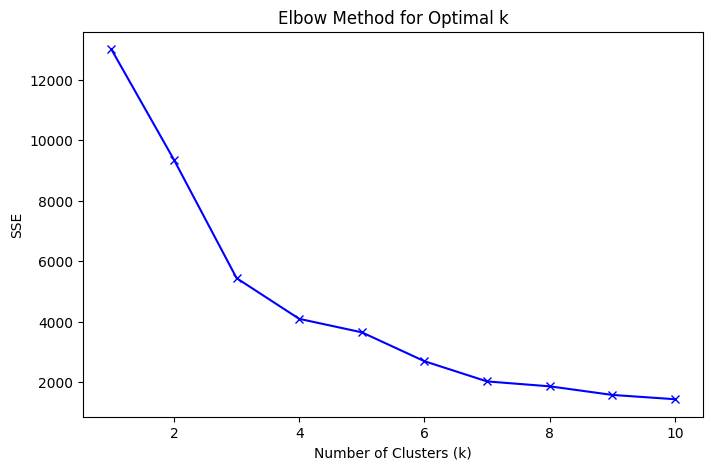

In [4]:
# Step 5: RFM Normalization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Step 6: Elbow Method to Find Optimal K
sse = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(8,5))
plt.plot(K, sse, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

# K-Means Clustering

In [5]:
# Use k=4 based on elbow (you can adjust as needed)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Step 8: Cluster Profiling
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'}).sort_values(by='Count', ascending=False)

print(cluster_summary)

            Recency  Frequency       Monetary  Count
Cluster                                             
3         43.910580   3.655748    1349.698298   3053
1        248.564030   1.551789     478.107581   1062
0         15.672986  22.047393   12453.225924    211
2          7.384615  82.692308  127338.313846     13


# Visualization

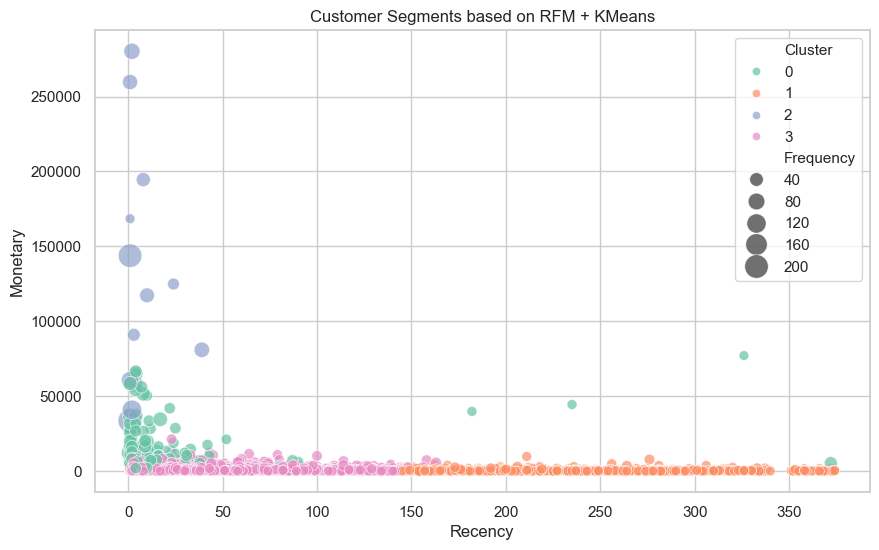

In [6]:
# Reset index for plotting
rfm_plot = rfm.reset_index()

# 3D Scatter Plot
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Recency', y='Monetary', hue='Cluster',
    size='Frequency', data=rfm_plot, palette='Set2', sizes=(50, 300), alpha=0.7
)
plt.title('Customer Segments based on RFM + KMeans')
plt.show()